In [1]:
import os

# Check current working directory
print("Current directory:", os.getcwd())

# Change directory
os.chdir("/lab/deasylab3/Himangi/psg/")

# Verify change
print("New directory:", os.getcwd())

Current directory: /cluster/home/srivash/venvs/Mussel/path_gene_multimodal
New directory: /lab/deasylab3/Himangi/psg


In [2]:
png_dir = 'tile1.png'
from pathlib import Path

outdir = "hovernet_tile_output_tile7/"



In [3]:
import sys
sys.path.append("/cluster/home/srivash/venvs/Mussel/hover_next_inference/src")

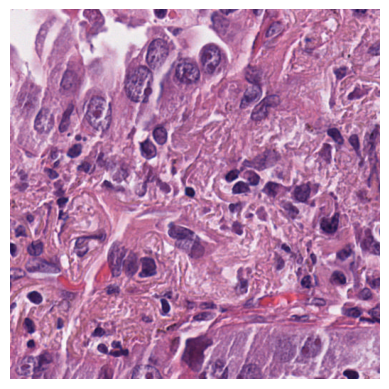

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(png_dir)
plt.imshow(img)
plt.axis('off')  # optional, hides axes
plt.show()


In [5]:
params = {
    "input": png_dir,
    "output_dir": outdir,
    "cp": "pannuke_convnextv2_tiny_3",   # or any of the VALID_WEIGHTS
    "metric": "f1",
    "batch_size": 32,
    "tta": 4,
    "save_polygon": True,
    "tile_size": 256,
    "overlap": 0.96875,
    "inf_workers": 4,
    "inf_writers": 2,
    "pp_tiling": 8,
    "pp_overlap": 256,
    "pp_workers": 16,
    "keep_raw": False,
    "cache": "/tmp",
    "only_inference": False,
}


In [6]:
import os
import argparse
import sys
from timeit import default_timer as timer
from datetime import timedelta
import torch
from glob import glob
from inference.inference import inference_main, get_inference_setup
from inference.post_process import post_process_main
from inference.data_utils import copy_img

torch.backends.cudnn.benchmark = True
print(torch.cuda.device_count(), " cuda devices")


def prepare_input(params):
    """
    Check if input is a text file, glob pattern, or a directory, and return a list of input files

    Parameters
    ----------
    params: dict
        input parameters from argparse

    Returns
    -------
    list
        List of input file paths

    Raises
    ------
    FileNotFoundError
        If the input file or pattern does not exist
    ValueError
        If no files match the pattern
    """
    print("Input specified:", params["input"])
    
    if params["input"].endswith(".txt"):
        if os.path.exists(params["input"]):
            with open(params["input"], "r") as f:
                input_list = [line.strip() for line in f if line.strip()]
            if not input_list:
                raise ValueError(f"Text file {params['input']} is empty or contains no valid paths")
        else:
            raise FileNotFoundError(f"Input text file not found: {params['input']}")
    else:
        input_list = sorted(glob(params["input"].rstrip()))
        if not input_list:
            raise ValueError(f"No files found matching pattern: {params['input']}")
    
    print(f"Found {len(input_list)} file(s) to process")
    return input_list


def get_input_type(params):
    """
    Check if input is an image, numpy array, or whole slide image, and return the input type
    If you are trying to process other images that are supported by opencv (e.g. tiff), you can add the extension to the list

    Parameters
    ----------
    params: dict
        input parameters from argparse
    """
    params["ext"] = os.path.splitext(params["p"])[-1]
    if params["ext"] == ".npy":
        params["input_type"] = "npy"
    elif params["ext"] in [".jpg", ".png", ".jpeg", ".bmp"]:
        params["input_type"] = "img"
    else:
        params["input_type"] = "wsi"
    return params


def infer(params: dict):
    """
    Start nuclei segmentation and classification pipeline using specified parameters from argparse

    Parameters
    ----------
    params: dict
        input parameters from argparse
    
    Raises
    ------
    ValueError
        If required parameters are invalid
    """
    
    # Validate checkpoint parameter
    if not params["cp"]:
        raise ValueError("Checkpoint parameter (--cp) is required. Please specify a model checkpoint.")
    
    # Validate metric
    if params["metric"] not in ["mpq", "f1", "pannuke"]:
        print(f"Warning: Invalid metric '{params['metric']}', falling back to 'f1'")
        params["metric"] = "f1"
    else:
        print(f"Optimizing postprocessing for: {params['metric']}")

    params["data_dirs"] = params["cp"].split(",")
    
    # Create output directory if it doesn't exist
    os.makedirs(params["output_dir"], exist_ok=True)
    print(f"Results will be saved to: {params['output_dir']}")
    print(f"Loading model from: {params['data_dirs']}")

    # Run per tile inference and store results
    params, models, augmenter, color_aug_fn = get_inference_setup(params)

    input_list = prepare_input(params)
    print("Running inference on", len(input_list), "file(s)")

    for inp in input_list:
        start_time = timer()
        params["p"] = inp.rstrip()
        params = get_input_type(params)
        print("Processing ", params["p"])
        if params["cache"] is not None:
            print("Caching input at:")
            params["p"] = copy_img(params["p"], params["cache"])
            print(params["p"])

        params, z = inference_main(params, models, augmenter, color_aug_fn)
        print(
            "::: finished or skipped inference after",
            timedelta(seconds=timer() - start_time),
        )
        process_timer = timer()
        if params["only_inference"]:
            try:
                z[0].store.close()
                z[1].store.close()
            except TypeError:
                # if z is None, z cannot be indexed -> throws a TypeError
                pass
            print("Exiting after inference")
            sys.exit(2)
        # Stitch tiles together and postprocess to get instance segmentation
        if not os.path.exists(os.path.join(params["output_dir"], "pinst_pp.zip")):
            print("running post-processing")

            z_pp = post_process_main(
                params,
                z,
            )
            if not params["keep_raw"]:
                try:
                    os.remove(params["model_out_p"] + "_inst.zip")
                    os.remove(params["model_out_p"] + "_cls.zip")
                except FileNotFoundError:
                    pass
        else:
            z_pp = None
        print(
            "::: postprocessing took",
            timedelta(seconds=timer() - process_timer),
            "total elapsed time",
            timedelta(seconds=timer() - start_time),
        )
        if z_pp is not None:
            z_pp.store.close()
    print("done")

/cluster/home/srivash/miniforge3/envs/hovernext/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1  cuda devices


In [7]:
infer(params)

Optimizing postprocessing for: f1
Results will be saved to: hovernet_tile_output_tile7/
Loading model from: ['pannuke_convnextv2_tiny_3']
succesfully loaded model weights
processing input using pannuke trained model
Input specified: tile1.png
Found 1 file(s) to process
Running inference on 1 file(s)
Processing  tile1.png
Caching input at:
/tmp/tile1.png


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]


::: finished or skipped inference after 0:00:03.242492
running post-processing
[0.7 0.7 0.6 0.6 0.7] [0.4 0.5 0.4 0.1 0.5]


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

saving final output
storing class dictionary...
::: postprocessing took 0:00:01.761361 total elapsed time 0:00:05.004084
done


In [10]:
import os
import json
import uuid

import numpy as np
import pandas as pd
import zarr
from skimage.measure import regionprops, find_contours
from skimage.measure import approximate_polygon

# ------------------------
# 1. Parse class_inst.json
# ------------------------
with open(os.path.join(outdir, "class_inst.json"), "r") as f:
    class_info = json.load(f)

rows = []
for key, val in class_info.items():
    inst_id = int(key)       # instance label in pinst_pp
    type_id = int(val[0])    # e.g. 0..4 or 1..5 depending on pipeline

    # val[1] = [0, cx, cy] -> ignore the 0
    _, cx, cy = val[1]
    centroid = [float(cx), float(cy)]

    rows.append(
        {
            "inst_id": inst_id,
            "type": type_id,
            "centroid": centroid,
        }
    )

df = pd.DataFrame(rows)

# ------------------------
# 2. Load instance map and ensure correct shape
# ------------------------
z = zarr.open(os.path.join(outdir, "pinst_pp.zip"), mode="r")
inst_map = np.asarray(z)

# handle shapes like (1, H, W)
if inst_map.ndim == 3:
    inst_map = inst_map[0]

H, W = inst_map.shape
print("inst_map shape:", inst_map.shape)

# ------------------------
# 3. Bounding boxes and polygons per instance
# ------------------------
props = regionprops(inst_map)  # one region per instance label

bbox_dict = {}
poly_dict = {}

for r in props:
    inst_id = r.label

    # bounding box
    min_row, min_col, max_row, max_col = r.bbox
    bbox_dict[inst_id] = [int(min_col), int(min_row),
                          int(max_col), int(max_row)]  # [x_min, y_min, x_max, y_max]

    # full-image binary mask for this nucleus
    mask = (inst_map == inst_id)

    # find contours on full mask
    contours = find_contours(mask.astype(float), level=0.5)
    if not contours:
        continue

    # choose longest contour
    contour = max(contours, key=lambda c: c.shape[0])

    # contour is in (row, col) = (y, x)
    ys = contour[:, 0]
    xs = contour[:, 1]

    # [x, y] coords
    poly_coords = np.stack([xs, ys], axis=1)

    # OPTIONAL: smooth jaggy pixels a bit
    poly_simplified = approximate_polygon(poly_coords, tolerance=0.5)
    poly = poly_simplified.tolist()

    poly_dict[inst_id] = poly

df["bounding_box"] = df["inst_id"].map(bbox_dict.get)
df["polygon"]       = df["inst_id"].map(poly_dict.get)

# ------------------------
# 4. Map type -> type_name
# ------------------------
# CAREFUL: this mapping must match your model’s class order
# What you wrote:
TYPE_NAMES = {
    1: "neoplastic",
    2: "inflammatory",
    3: "connective",
    4: "dead",
    5: "epithelial",
}

df["type_name"] = df["type"].map(TYPE_NAMES)

# ------------------------
# 5. Add nuc_id
# ------------------------
df["nuc_id"] = df["inst_id"].apply(lambda _: uuid.uuid4().hex)

final_df = df[[
    "nuc_id", "inst_id", "type", "type_name",
    "bounding_box", "centroid", "polygon"
]]

print(final_df)


inst_map shape: (521, 521)
                               nuc_id  inst_id  type     type_name  \
0    9b82fa99ef114d899b3e1f742b70e96d        1     2  inflammatory   
1    1b3e6dd8c73a4a11b243812cb42ce05d        2     1    neoplastic   
2    6aef913cf485484192908ec6024eb70c        3     3    connective   
3    fda4a57e31d44cf18490829f2ecda2b7        4     1    neoplastic   
4    223e4ea9c4674f529d1bf4290dd21764        5     1    neoplastic   
..                                ...      ...   ...           ...   
96   0903a317191b4191a46b7b819ce5923f       97     3    connective   
97   9e935a70c53c4b92b85136eafd6b792f       98     1    neoplastic   
98   4d2a38246da1482c88996f2c6a735256       99     1    neoplastic   
99   8df6aec4ec994a7ebcd671052866b4d7      100     1    neoplastic   
100  7c090b03627e4395a18a374695a5c497      101     2  inflammatory   

             bounding_box                                  centroid  \
0       [203, 1, 220, 14]   [6.142857142857143, 211.268571428

In [11]:
df

,inst_id,type,centroid,bounding_box,polygon,type_name,nuc_id
0,1,2,"[6.142857142857143, 211.26857142857142]","[203, 1, 220, 14]","[[214.0, 13.5], [208.0, 12.5], [204.5, 9.0], [...",inflammatory,9b82fa99ef114d899b3e1f742b70e96d
1,2,1,"[22.64962121212121, 296.1723484848485]","[283, 12, 310, 38]","[[300.0, 37.5], [296.0, 37.5], [294.0, 35.5], ...",neoplastic,1b3e6dd8c73a4a11b243812cb42ce05d
2,3,3,"[28.736141906873613, 372.11529933481154]","[359, 17, 386, 41]","[[365.0, 40.5], [361.0, 40.5], [358.5, 39.0], ...",connective,6aef913cf485484192908ec6024eb70c
3,4,1,"[30.28813559322034, 232.37853107344634]","[223, 25, 243, 38]","[[234.0, 37.5], [231.0, 37.5], [227.5, 35.0], ...",neoplastic,fda4a57e31d44cf18490829f2ecda2b7
4,5,1,"[62.17614165890028, 206.6551724137931]","[191, 41, 224, 85]","[[205.0, 84.5], [200.0, 84.5], [195.5, 81.0], ...",neoplastic,223e4ea9c4674f529d1bf4290dd21764
...,...,...,...,...,...,...,...
96,97,3,"[496.764060356653, 36.61454046639232]","[15, 483, 60, 509]","[[37.0, 508.5], [34.0, 508.5], [33.0, 507.5], ...",connective,0903a317191b4191a46b7b819ce5923f
97,98,1,"[503.7413793103448, 338.1666666666667]","[326, 499, 352, 508]","[[351.0, 507.5], [326.0, 507.5], [325.5, 506.0...",neoplastic,9e935a70c53c4b92b85136eafd6b792f
98,99,1,"[505.1333333333333, 178.64444444444445]","[173, 502, 184, 508]","[[183.0, 507.5], [172.5, 507.0], [178.0, 501.5...",neoplastic,4d2a38246da1482c88996f2c6a735256
99,100,1,"[504.7448979591837, 195.30612244897958]","[187, 501, 207, 508]","[[206.0, 507.5], [187.0, 507.5], [186.5, 505.0...",neoplastic,8df6aec4ec994a7ebcd671052866b4d7


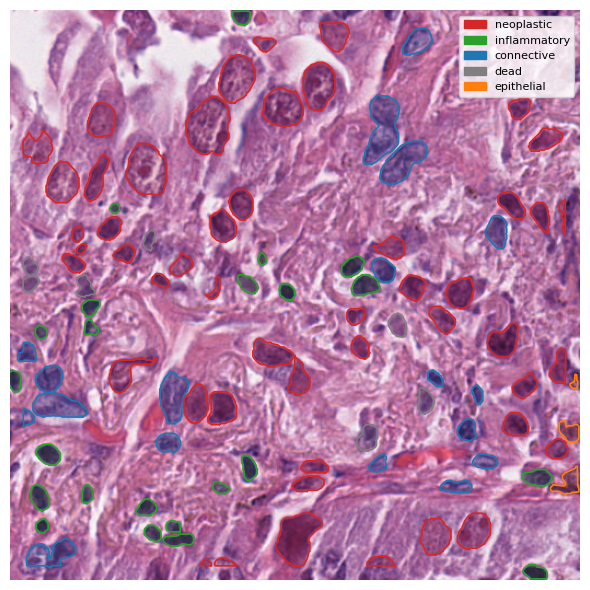

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Correct PanNuke mapping for your df["type"] (1..5)
TYPE_NAMES = {
    1: "neoplastic",
    2: "inflammatory",
    3: "connective",
    4: "dead",
    5: "epithelial",
}

# Choose colors for each type id
CLASS_COLORS = {
    1: "tab:red",      # neoplastic
    2: "tab:green",    # inflammatory
    3: "tab:blue",     # connective
    4: "tab:gray",     # dead
    5: "tab:orange",   # epithelial
}

fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(img)

for _, row in final_df.iterrows():
    poly = row["polygon"]
    # be safe with None / empty
    if poly is None or len(poly) == 0:
        continue

    poly_arr = np.asarray(poly, dtype=float)
    xs = poly_arr[:, 0]
    ys = poly_arr[:, 1]

    t = int(row["type"])  # 0..4 from PanNuke
    color = CLASS_COLORS.get(t, "yellow")

    ax.plot(xs, ys, color=color, linewidth=1.2)
    ax.fill(xs, ys, color=color, alpha=0.15)

ax.set_axis_off()

# sort by class id so legend has a stable, logical order
legend_patches = [
    mpatches.Patch(color=CLASS_COLORS[t_id], label=t_name)
    for t_id, t_name in sorted(TYPE_NAMES.items(), key=lambda x: x[0])
]

ax.legend(handles=legend_patches, loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


In [12]:
df[df["type_name"] == "neoplastic"]

,inst_id,type,centroid,bounding_box,polygon,type_name,nuc_id
1,2,1,"[22.64962121212121, 296.1723484848485]","[283, 12, 310, 38]","[[300.0, 37.5], [296.0, 37.5], [294.0, 35.5], ...",neoplastic,1b3e6dd8c73a4a11b243812cb42ce05d
3,4,1,"[30.28813559322034, 232.37853107344634]","[223, 25, 243, 38]","[[234.0, 37.5], [231.0, 37.5], [227.5, 35.0], ...",neoplastic,fda4a57e31d44cf18490829f2ecda2b7
4,5,1,"[62.17614165890028, 206.6551724137931]","[191, 41, 224, 85]","[[205.0, 84.5], [200.0, 84.5], [195.5, 81.0], ...",neoplastic,223e4ea9c4674f529d1bf4290dd21764
5,6,1,"[68.59563924677899, 281.7611496531219]","[268, 48, 297, 92]","[[284.0, 91.5], [278.0, 91.5], [277.0, 90.5], ...",neoplastic,e15fdfd5366f4326b9190ec8bb727f9b
6,7,1,"[58.11764705882353, 506.29411764705884]","[505, 54, 508, 62]","[[507.0, 61.5], [506.0, 61.5], [504.5, 60.0], ...",neoplastic,2205818c028b4f1ca9aa79f910cd4d16
7,8,1,"[89.08341511285575, 249.090284592738]","[231, 71, 268, 107]","[[251.0, 106.5], [239.0, 103.5], [237.0, 101.5...",neoplastic,d5f17d788da241adb535efc7498e0c1f
9,10,1,"[106.3700495049505, 181.33539603960395]","[161, 79, 201, 132]","[[192.0, 131.5], [187.0, 131.5], [185.0, 128.5...",neoplastic,3967bcd6bd3043b797f76404bc6155b2
10,11,1,"[89.11643835616438, 465.3527397260274]","[456, 80, 476, 100]","[[466.0, 99.5], [461.0, 99.5], [458.5, 97.0], ...",neoplastic,755071b9305a4696a1c0eee3b9be0173
11,12,1,"[100.56377952755905, 83.17007874015748]","[71, 85, 96, 116]","[[84.0, 115.5], [78.0, 115.5], [75.0, 113.5], ...",neoplastic,70fc89f42b0a4a24b3c2f0abc44edaa9
12,13,1,"[125.9382940108893, 25.098003629764065]","[12, 110, 39, 141]","[[25.0, 140.5], [20.5, 139.0], [19.5, 138.0], ...",neoplastic,d4096a740af14921a4dc2a7bde04842f


Nodes: 101
Edges: 300
                                  9b82fa99ef114d899b3e1f742b70e96d  \
9b82fa99ef114d899b3e1f742b70e96d                          0.000000   
1b3e6dd8c73a4a11b243812cb42ce05d                         86.493495   
6aef913cf485484192908ec6024eb70c                          0.000000   
fda4a57e31d44cf18490829f2ecda2b7                         32.072182   
223e4ea9c4674f529d1bf4290dd21764                         56.222882   

                                  1b3e6dd8c73a4a11b243812cb42ce05d  \
9b82fa99ef114d899b3e1f742b70e96d                         86.493495   
1b3e6dd8c73a4a11b243812cb42ce05d                          0.000000   
6aef913cf485484192908ec6024eb70c                         76.186465   
fda4a57e31d44cf18490829f2ecda2b7                         64.249498   
223e4ea9c4674f529d1bf4290dd21764                          0.000000   

                                  6aef913cf485484192908ec6024eb70c  \
9b82fa99ef114d899b3e1f742b70e96d                          0.000000

/tmp/ipykernel_3547111/430627625.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


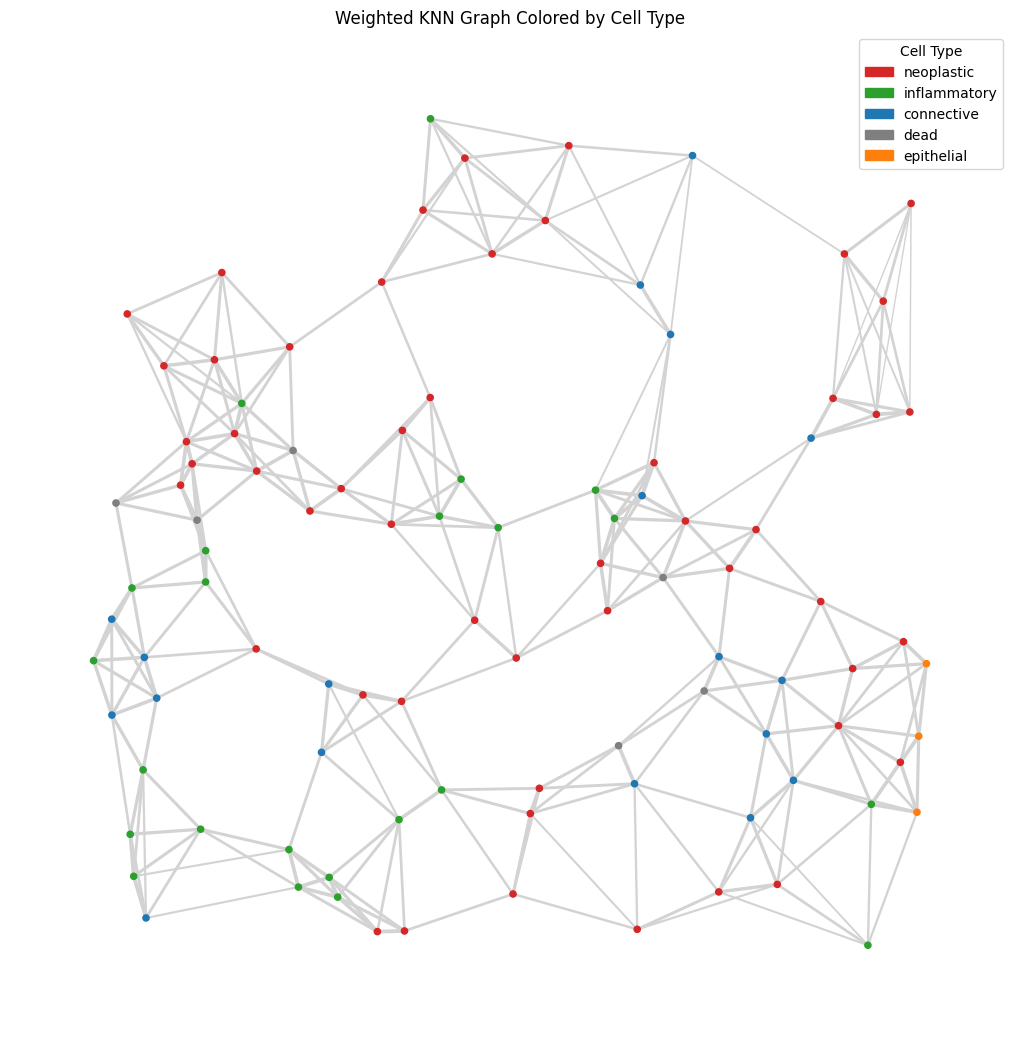

/tmp/ipykernel_3547111/430627625.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["centroid_geom"]          = gdf["centroid_geom"]
/tmp/ipykernel_3547111/430627625.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["type_id"]                = gdf["type_id"]
/tmp/ipykernel_3547111/430627625.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from libpysal.weights import KNN
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ----------------------------------------------------
# Type + color mappings
# ----------------------------------------------------
TYPE_NAMES = {
    1: "neoplastic",
    2: "inflammatory",
    3: "connective",
    4: "dead",
    5: "epithelial",
}

CLASS_COLORS = {
    1: "tab:red",      # neoplastic
    2: "tab:green",    # inflammatory
    3: "tab:blue",     # connective
    4: "tab:gray",     # dead
    5: "tab:orange",   # epithelial
}

# Reverse map: name -> id (to map type_name column)
NAME_TO_ID = {v: k for k, v in TYPE_NAMES.items()}

# ----------------------------------------------------
# 1. Prepare GeoDataFrame from final_df
# ----------------------------------------------------
df = final_df.copy()   # work on a copy

# centroid is [y, x] → Point(x, y)
df["centroid_geom"] = df["centroid"].apply(lambda c: Point(c[1], c[0]))

gdf = gpd.GeoDataFrame(df, geometry="centroid_geom")

# Map type_name -> type_id
if "type_id" not in gdf.columns:
    if "type_name" in gdf.columns:
        gdf["type_id"] = gdf["type_name"].map(NAME_TO_ID)
    elif "type" in gdf.columns:
        gdf["type_id"] = gdf["type"]  # assumes compatible coding
    else:
        raise ValueError("No type_name or type column found to map cell types.")

# ----------------------------------------------------
# 2. KNN graph (indices neighbors)
# ----------------------------------------------------
coords = np.array([[p.x, p.y] for p in gdf["centroid_geom"]])

k = 5  # change if needed
knn = KNN.from_array(coords, k=k)

# list of neighbor indices per row
gdf["knn_neighbors"] = gdf.index.map(lambda i: knn.neighbors[i])

# ----------------------------------------------------
# 3. Neighbor points, coords, distances
# ----------------------------------------------------
def get_point(idx):
    return gdf.loc[idx, "centroid_geom"]

# Points
gdf["knn_neighbor_points"] = gdf["knn_neighbors"].apply(
    lambda neighbors: [get_point(i) for i in neighbors]
)

# Coordinate tuples (x, y)
gdf["knn_neighbor_coords"] = gdf["knn_neighbors"].apply(
    lambda neighbors: [(get_point(i).x, get_point(i).y) for i in neighbors]
)

# Euclidean distances to neighbors
def neighbor_distances(row):
    x0, y0 = row["centroid_geom"].x, row["centroid_geom"].y
    dists = []
    for idx in row["knn_neighbors"]:
        p = get_point(idx)
        dx = x0 - p.x
        dy = y0 - p.y
        dists.append(np.sqrt(dx*dx + dy*dy))
    return dists

gdf["knn_neighbor_distances"] = gdf.apply(neighbor_distances, axis=1)

# ----------------------------------------------------
# 4. Color per node based on type_id
# ----------------------------------------------------
def get_color(type_id):
    if pd.isna(type_id):
        return "black"   # fallback
    return CLASS_COLORS.get(int(type_id), "black")

gdf["color"] = gdf["type_id"].apply(get_color)

# ----------------------------------------------------
# 5. Build NetworkX weighted graph from KNN
# ----------------------------------------------------
G_knn = nx.Graph()

# Add nodes with attributes
for i, row in gdf.iterrows():
    nid = row["nuc_id"]
    G_knn.add_node(
        nid,
        type_id=row["type_id"],
        type_name=row.get("type_name", None),
        color=row["color"],
        pos=(row["centroid_geom"].x, row["centroid_geom"].y),
    )

# Add edges with Euclidean distance as weight
for i, neighbors in gdf["knn_neighbors"].items():
    src_id = gdf.loc[i, "nuc_id"]
    x0, y0 = gdf.loc[i, "centroid_geom"].x, gdf.loc[i, "centroid_geom"].y
    for j in neighbors:
        trg_id = gdf.loc[j, "nuc_id"]
        if src_id == trg_id:
            continue
        x1, y1 = gdf.loc[j, "centroid_geom"].x, gdf.loc[j, "centroid_geom"].y
        dist = np.sqrt((x0 - x1)**2 + (y0 - y1)**2)
        # Add edge; if it exists, keep the smaller weight
        if G_knn.has_edge(src_id, trg_id):
            G_knn.edges[src_id, trg_id]["weight"] = min(
                G_knn.edges[src_id, trg_id]["weight"], dist
            )
        else:
            G_knn.add_edge(src_id, trg_id, weight=dist)

print("Nodes:", G_knn.number_of_nodes())
print("Edges:", G_knn.number_of_edges())

# ----------------------------------------------------
# 6. Optional: weighted adjacency matrix
# ----------------------------------------------------
A_knn_df = nx.to_pandas_adjacency(G_knn, dtype=float, weight="weight")
print(A_knn_df.head())

# ----------------------------------------------------
# 7. Optional: visualize the weighted, colored graph
# ----------------------------------------------------
pos = nx.get_node_attributes(G_knn, "pos")
node_colors = [G_knn.nodes[n]["color"] for n in G_knn.nodes()]
edge_weights = [G_knn.edges[u, v]["weight"] for u, v in G_knn.edges()]

# you can map weights to widths (e.g. inverse distance)
max_w = max(edge_weights) if edge_weights else 1.0
edge_widths = [1.0 + 2.0*(1.0 - (w / max_w)) for w in edge_weights]  # thinner for long edges

plt.figure(figsize=(10, 10))

nx.draw(
    G_knn,
    pos,
    node_color=node_colors,
    node_size=20,
    edge_color="lightgray",
    width=edge_widths,
    with_labels=False,
)

plt.title("Weighted KNN Graph Colored by Cell Type")
plt.gca().invert_yaxis()
plt.axis("equal")
plt.tight_layout()

# Legend
handles = []
for t_id, name in TYPE_NAMES.items():
    color = CLASS_COLORS.get(t_id, "black")
    handles.append(mpatches.Patch(color=color, label=name))
plt.legend(handles=handles, title="Cell Type", loc="upper right")

plt.show()

# ----------------------------------------------------
# 8. Copy key columns back into final_df (if desired)
# ----------------------------------------------------
final_df["centroid_geom"]          = gdf["centroid_geom"]
final_df["type_id"]                = gdf["type_id"]
final_df["color"]                  = gdf["color"]
final_df["knn_neighbors"]          = gdf["knn_neighbors"]
final_df["knn_neighbor_points"]    = gdf["knn_neighbor_points"]
final_df["knn_neighbor_coords"]    = gdf["knn_neighbor_coords"]
final_df["knn_neighbor_distances"] = gdf["knn_neighbor_distances"]


Filtered nodes: 74
Filtered edges: 174


/tmp/ipykernel_3547111/2628398018.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


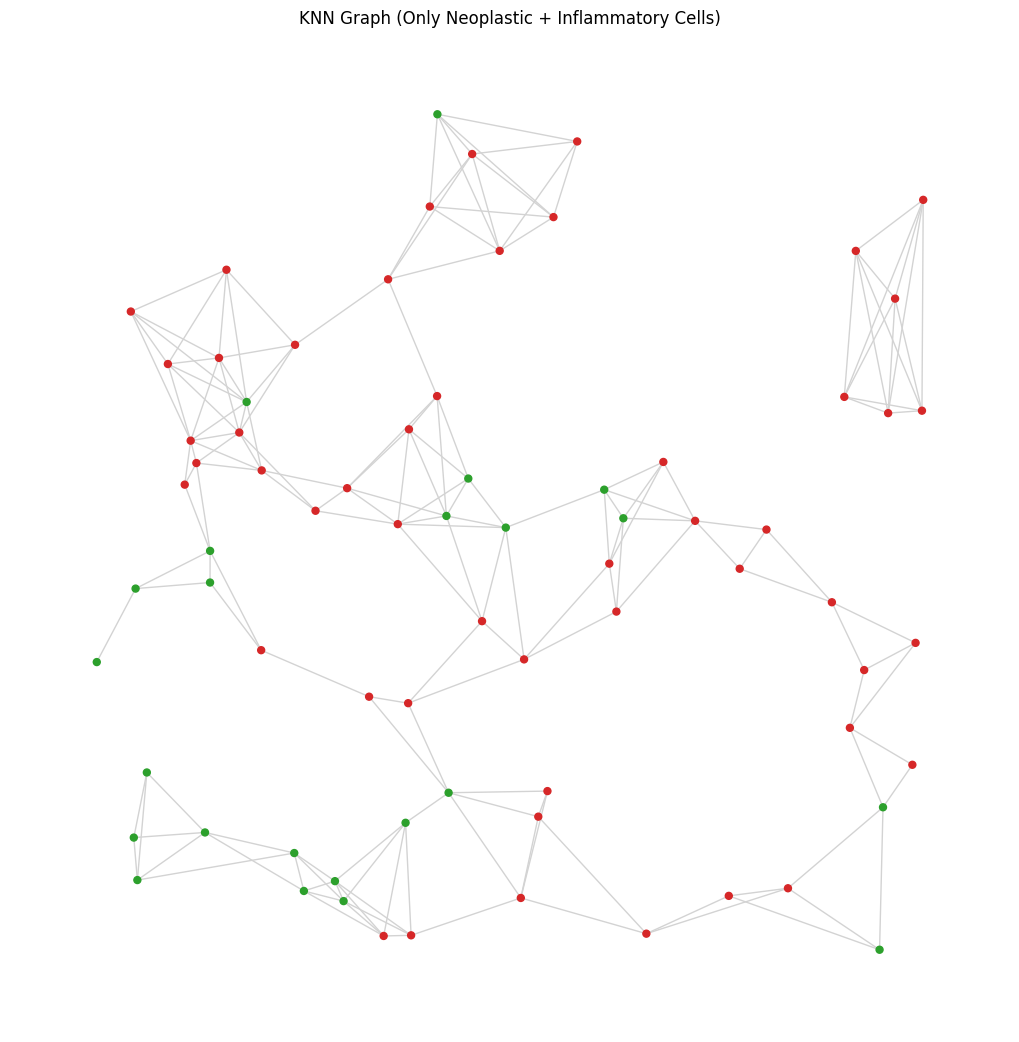

In [22]:
# Type IDs you want to keep
KEEP_TYPES = {1, 2}   # 1 = neoplastic, 2 = inflammatory
# Create a filtered graph
G_filtered = nx.Graph()

for n, data in G_knn.nodes(data=True):
    if data["type_id"] in KEEP_TYPES:
        G_filtered.add_node(n, **data)

# Add edges only if BOTH nodes are in the filtered graph
for u, v, data in G_knn.edges(data=True):
    if u in G_filtered and v in G_filtered:
        G_filtered.add_edge(u, v, **data)

print("Filtered nodes:", G_filtered.number_of_nodes())
print("Filtered edges:", G_filtered.number_of_edges())

pos = nx.get_node_attributes(G_filtered, "pos")
node_colors = [G_filtered.nodes[n]["color"] for n in G_filtered.nodes()]
edge_widths = [G_filtered.edges[u, v]["weight"] for u, v in G_filtered.edges()]

plt.figure(figsize=(10, 10))

nx.draw(
    G_filtered,
    pos,
    node_color=node_colors,
    edge_color="lightgray",
    node_size=25,
    with_labels=False
)

plt.title("KNN Graph (Only Neoplastic + Inflammatory Cells)")
plt.gca().invert_yaxis()
plt.axis("equal")
plt.tight_layout()

plt.show()


In [23]:
final_df["x_px"] = final_df["centroid"].apply(lambda c: float(c[0]))
final_df["y_px"] = final_df["centroid"].apply(lambda c: float(c[1]))


In [25]:
mpp_x = 0.25  # microns per pixel along X
mpp_y = 0.25  # microns per pixel along Y


In [26]:
final_df["x_um"] = final_df["x_px"] * mpp_x
final_df["y_um"] = final_df["y_px"] * mpp_y


/tmp/ipykernel_1410999/3074907282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["x_um"] = final_df["x_px"] * mpp_x
/tmp/ipykernel_1410999/3074907282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["y_um"] = final_df["y_px"] * mpp_y


In [27]:
x_med = final_df["x_um"].median()
y_med = final_df["y_um"].median()

final_df["x_um_centered"] = final_df["x_um"] - x_med
final_df["y_um_centered"] = final_df["y_um"] - y_med


/tmp/ipykernel_1410999/4035787966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["x_um_centered"] = final_df["x_um"] - x_med
/tmp/ipykernel_1410999/4035787966.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["y_um_centered"] = final_df["y_um"] - y_med


In [28]:
final_df

,nuc_id,inst_id,type,type_name,bounding_box,centroid,polygon,x_px,y_px,x_um,y_um,x_um_centered,y_um_centered
0,8b1c7235bec74c4f9e1eead3105e3388,1,2,epithelial,"[203, 1, 220, 14]","[6.142857142857143, 211.26857142857142]","[[214.0, 13.5], [208.0, 12.5], [204.5, 9.0], [...",6.142857,211.268571,1.535714,52.817143,-72.010582,-5.277490
1,22289eac721d4e18b5790a7771f64693,2,1,dead,"[283, 12, 310, 38]","[22.64962121212121, 296.1723484848485]","[[300.0, 37.5], [296.0, 37.5], [285.5, 28.0], ...",22.649621,296.172348,5.662405,74.043087,-67.883891,15.948454
2,1b6a601e3fda4b49b9e855df9c5490e4,3,3,inflammatory,"[359, 17, 386, 41]","[28.736141906873613, 372.11529933481154]","[[365.0, 40.5], [358.5, 39.0], [358.5, 33.0], ...",28.736142,372.115299,7.184035,93.028825,-66.362261,34.934192
3,23fc2190184c4b0181ab1616fda106d4,4,1,dead,"[223, 25, 243, 38]","[30.28813559322034, 232.37853107344634]","[[234.0, 37.5], [231.0, 37.5], [227.5, 35.0], ...",30.288136,232.378531,7.572034,58.094633,-65.974262,0.000000
4,d4391d6d9d64410180580cf428b016e5,5,1,dead,"[191, 41, 224, 85]","[62.17614165890028, 206.6551724137931]","[[205.0, 84.5], [200.0, 84.5], [195.5, 81.0], ...",62.176142,206.655172,15.544035,51.663793,-58.002261,-6.430840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,a19cc87e070e470ab12156e5a98ffb20,97,3,inflammatory,"[15, 483, 60, 509]","[496.764060356653, 36.61454046639232]","[[37.0, 508.5], [15.0, 507.5], [14.5, 501.0], ...",496.764060,36.614540,124.191015,9.153635,50.644719,-48.940998
97,3f687b4337dd4b6a8dd3359c0538376a,98,1,dead,"[326, 499, 352, 508]","[503.7413793103448, 338.1666666666667]","[[351.0, 507.5], [326.0, 507.5], [325.5, 506.0...",503.741379,338.166667,125.935345,84.541667,52.389049,26.447034
98,bd2d50f628cf4c82b96154f0d53e4d8e,99,1,dead,"[173, 502, 184, 508]","[505.1333333333333, 178.64444444444445]","[[183.0, 507.5], [172.5, 507.0], [178.0, 501.5...",505.133333,178.644444,126.283333,44.661111,52.737037,-13.433522
99,b0f0ac4c8c594e67bc6ad8ac0a441bf6,100,1,dead,"[187, 501, 207, 508]","[504.7448979591837, 195.30612244897958]","[[206.0, 507.5], [187.0, 507.5], [186.5, 505.0...",504.744898,195.306122,126.186224,48.826531,52.639928,-9.268102


In [32]:
from skimage.measure import regionprops_table
import numpy as np
import pandas as pd

# inst_map: 2D array, same as before

props = regionprops_table(
    inst_map,
    properties=(
        "label",
        "area",
        "perimeter",
        "eccentricity",
        "solidity",
        "major_axis_length",
        "minor_axis_length",
        "orientation",
    ),
)

morph_df = pd.DataFrame(props)
morph_df.rename(columns={"label": "inst_id"}, inplace=True)

# --- derived features ---

# 1) perimeter / area (avoid div0)
morph_df["perimeter_area"] = (
    morph_df["perimeter"] / morph_df["area"].clip(lower=1)
)

# 2) compactness: 4πA / P²  (≈1 for circles, <1 for irregular)
morph_df["compactness"] = (
    4.0 * np.pi * morph_df["area"]
    / morph_df["perimeter"].clip(lower=1) ** 2
)

# 3) roundness: 4A / (π·major_axis²)  (≈1 for circles)
morph_df["roundness"] = (
    4.0 * morph_df["area"]
    / (np.pi * morph_df["major_axis_length"].clip(lower=1) ** 2)
)

# 4) elongation: major / minor axis
morph_df["elongation"] = (
    morph_df["major_axis_length"]
    / morph_df["minor_axis_length"].clip(lower=1)
)



In [33]:
final_df = final_df.merge(morph_df, on="inst_id", how="left")


In [34]:
final_df

,nuc_id,inst_id,type,type_name,bounding_box,centroid,polygon,x_px,y_px,x_um,...,perimeter,eccentricity,solidity,major_axis_length,minor_axis_length,orientation,perimeter_area,compactness,roundness,elongation
0,8b1c7235bec74c4f9e1eead3105e3388,1,2,epithelial,"[203, 1, 220, 14]","[6.142857142857143, 211.26857142857142]","[[214.0, 13.5], [208.0, 12.5], [204.5, 9.0], [...",6.142857,211.268571,1.535714,...,48.970563,0.612942,0.956284,17.111364,13.520166,1.454825,0.279832,0.917018,0.760990,1.265618
1,22289eac721d4e18b5790a7771f64693,2,1,dead,"[283, 12, 310, 38]","[22.64962121212121, 296.1723484848485]","[[300.0, 37.5], [296.0, 37.5], [285.5, 28.0], ...",22.649621,296.172348,5.662405,...,87.941125,0.466552,0.968807,28.158967,24.906426,0.677566,0.166555,0.857946,0.847834,1.130590
2,1b6a601e3fda4b49b9e855df9c5490e4,3,3,inflammatory,"[359, 17, 386, 41]","[28.736141906873613, 372.11529933481154]","[[365.0, 40.5], [358.5, 39.0], [358.5, 33.0], ...",28.736142,372.115299,7.184035,...,81.597980,0.771716,0.961620,30.345906,19.298996,-0.894433,0.180927,0.851192,0.623572,1.572409
3,23fc2190184c4b0181ab1616fda106d4,4,1,dead,"[223, 25, 243, 38]","[30.28813559322034, 232.37853107344634]","[[234.0, 37.5], [231.0, 37.5], [227.5, 35.0], ...",30.288136,232.378531,7.572034,...,51.455844,0.775175,0.936508,19.570430,12.363558,1.443057,0.290711,0.840067,0.588414,1.582912
4,d4391d6d9d64410180580cf428b016e5,5,1,dead,"[191, 41, 224, 85]","[62.17614165890028, 206.6551724137931]","[[205.0, 84.5], [200.0, 84.5], [195.5, 81.0], ...",62.176142,206.655172,15.544035,...,124.225397,0.723854,0.971041,44.577777,30.756594,-0.311411,0.115774,0.873753,0.687500,1.449373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,a19cc87e070e470ab12156e5a98ffb20,97,3,inflammatory,"[15, 483, 60, 509]","[496.764060356653, 36.61454046639232]","[[37.0, 508.5], [15.0, 507.5], [14.5, 501.0], ...",496.764060,36.614540,124.191015,...,145.189863,0.902934,0.826531,49.893953,21.443398,-1.305292,0.199163,0.434575,0.372857,2.326775
97,3f687b4337dd4b6a8dd3359c0538376a,98,1,dead,"[326, 499, 352, 508]","[503.7413793103448, 338.1666666666667]","[[351.0, 507.5], [326.0, 507.5], [325.5, 506.0...",503.741379,338.166667,125.935345,...,58.384776,0.925974,0.966667,25.002597,9.440639,-1.566250,0.335545,0.641446,0.354396,2.648401
98,bd2d50f628cf4c82b96154f0d53e4d8e,99,1,dead,"[173, 502, 184, 508]","[505.1333333333333, 178.64444444444445]","[[183.0, 507.5], [172.5, 507.0], [178.0, 501.5...",505.133333,178.644444,126.283333,...,25.313708,0.810633,1.000000,10.387373,6.082378,-1.444766,0.562527,0.882492,0.531020,1.707781
99,b0f0ac4c8c594e67bc6ad8ac0a441bf6,100,1,dead,"[187, 501, 207, 508]","[504.7448979591837, 195.30612244897958]","[[206.0, 507.5], [187.0, 507.5], [186.5, 505.0...",504.744898,195.306122,126.186224,...,44.727922,0.935917,0.933333,19.587214,6.899013,1.490952,0.456407,0.615571,0.325230,2.839133


In [35]:
cont_cols = [
    "area",
    "perimeter",
    "eccentricity",
    "solidity",
    "major_axis_length",
    "minor_axis_length",
    "perimeter_area",
    "compactness",
    "roundness",
    "elongation",
]

for col in cont_cols:
    if col in final_df.columns:
        mu = final_df[col].mean()
        sigma = final_df[col].std(ddof=0)
        if sigma == 0 or np.isnan(sigma):
            final_df[col + "_z"] = 0.0
        else:
            final_df[col + "_z"] = (final_df[col] - mu) / sigma


In [1]:
final_df

NameError: name 'final_df' is not defined

In [45]:
import torch
import numpy as np
type_onehot = pd.get_dummies(final_df["type"], prefix="type")
final_df = pd.concat([final_df, type_onehot], axis=1)

# choose columns for node features
onehot_cols = [c for c in final_df.columns if c.startswith("type_")]
morph_z_cols = [c for c in final_df.columns if c.endswith("_z")]

feat_cols = onehot_cols + morph_z_cols
print("Using features:", feat_cols)
from scipy.spatial import cKDTree
import numpy as np
import torch

coords = final_df[["x_um", "y_um"]].to_numpy()  # (101, 2)
tree = cKDTree(coords)

r = 40.0  # µm, adjust depending on cell density
pairs = tree.query_ball_tree(tree, r)

edges = []
for i, neighs in enumerate(pairs):
    for j in neighs:
        if i != j and i < j:
            edges.append((i, j))

edges = np.array(edges, dtype=np.int64)
print("undirected edges:", edges.shape)


Using features: ['type_name', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'area_z', 'perimeter_z', 'eccentricity_z', 'solidity_z', 'major_axis_length_z', 'minor_axis_length_z', 'perimeter_area_z', 'compactness_z', 'roundness_z', 'elongation_z']
undirected edges: (1189, 2)


In [46]:
edges

array([[  0,   1],
       [  0,   3],
       [  0,   4],
       ...,
       [ 97,  99],
       [ 97, 100],
       [ 98,  99]])

In [47]:
edge_index = np.vstack([edges.T, edges[:, ::-1].T])
edge_index = torch.tensor(edge_index, dtype=torch.long)
print("edge_index:", edge_index.shape)


edge_index: torch.Size([4, 1189])


In [48]:
dists = np.linalg.norm(coords[edges[:,0]] - coords[edges[:,1]], axis=1)
edge_attr = torch.tensor(np.concatenate([dists[:,None], dists[:,None]], axis=0),
                         dtype=torch.float32)
print("edge_attr:", edge_attr.shape)


edge_attr: torch.Size([2378, 1])


In [49]:
from torch_geometric.data import Data

data = Data(
    x=x,                          # node features (101 × 15)
    edge_index=edge_index,        # graph structure
    edge_attr=edge_attr,          # optional
)

print(data)


Data(x=[101, 15], edge_index=[4, 1189], edge_attr=[2378, 1])


In [50]:
final_df["x_px"] = final_df["centroid"].apply(lambda c: float(c[0]))
final_df["y_px"] = final_df["centroid"].apply(lambda c: float(c[1]))


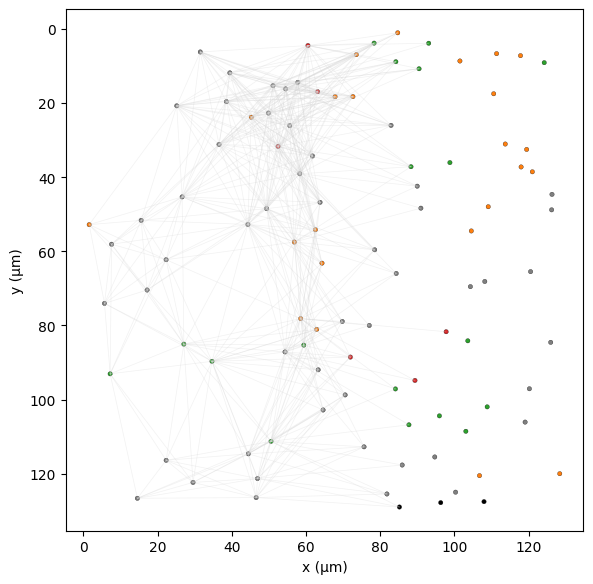

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch

coords_um = final_df[["x_um", "y_um"]].to_numpy()  # (N, 2)
types = final_df["type"].to_numpy()

src = edge_index[0].cpu().numpy()
dst = edge_index[1].cpu().numpy()

# color map for types
TYPE_COLORS = {
    0: "tab:blue",
    1: "tab:gray",
    2: "tab:orange",
    3: "tab:green",
    4: "tab:red",
}

node_colors = [TYPE_COLORS.get(t, "black") for t in types]

fig, ax = plt.subplots(figsize=(6, 6))

# scatter nodes
ax.scatter(
    coords_um[:, 0],
    coords_um[:, 1],
    s=10,
    c=node_colors,
    edgecolors="k",
    linewidths=0.2,
)

# draw a subset of edges (to avoid too much clutter)
max_edges_to_plot = 500
E = src.shape[0]
for e in range(min(E, max_edges_to_plot)):
    i = src[e]
    j = dst[e]
    x1, y1 = coords_um[i]
    x2, y2 = coords_um[j]
    ax.plot([x1, x2], [y1, y2], color="lightgray", alpha=0.3, linewidth=0.5)

ax.set_aspect("equal")
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.invert_yaxis()  # optional, to match image-like orientation
plt.tight_layout()
plt.show()


tile image shape: (521, 521, 3)


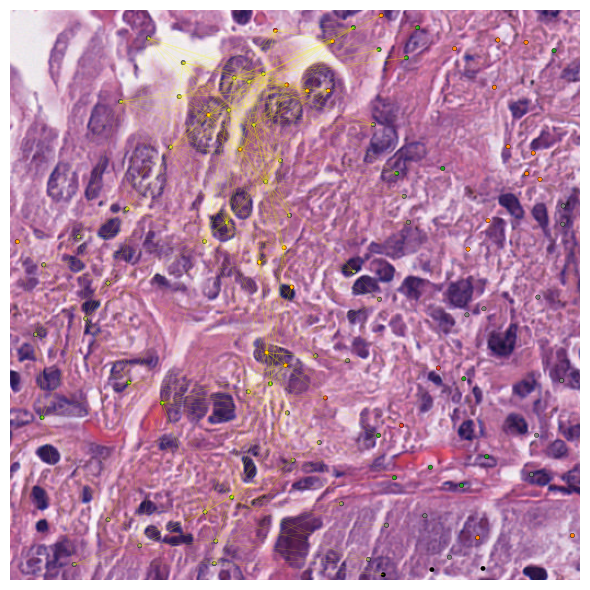

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# load tile
tile_path = png_dir  # update this
img = np.array(Image.open(tile_path).convert("RGB"))
H_img, W_img = img.shape[:2]
print("tile image shape:", img.shape)

# pixel coords for centroids
coords_px = final_df[["x_px", "y_px"]].to_numpy()
types = final_df["type"].to_numpy()

TYPE_COLORS = {
    0: "tab:blue",
    1: "tab:gray",
    2: "tab:orange",
    3: "tab:green",
    4: "tab:red",
}

node_colors = [TYPE_COLORS.get(t, "black") for t in types]

src = edge_index[0].cpu().numpy()
dst = edge_index[1].cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(img)

# draw edges first, so nodes are on top
max_edges_to_plot = 500
E = src.shape[0]
for e in range(min(E, max_edges_to_plot)):
    i = src[e]
    j = dst[e]
    x1, y1 = coords_px[i]
    x2, y2 = coords_px[j]
    ax.plot([x1, x2], [y1, y2], color="yellow", alpha=0.2, linewidth=0.5)

# draw nodes as small circles
ax.scatter(
    coords_px[:, 0],
    coords_px[:, 1],
    s=10,
    c=node_colors,
    edgecolors="k",
    linewidths=0.3,
)

ax.set_axis_off()
plt.tight_layout()
plt.show()
